In [4]:
# Fix the bugs that 
import pandas as pd
import json
import numpy as np
from PIL import Image
import os.path as osp
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import matplotlib; matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pylab
import cv2
import glob
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

D:\software\software_files\x64\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "D:\software\software_files\x64\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\software\software_files\x64\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\software\software_files\x64\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\software\software_files\x64\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\software\software_files\x64\Anaconda3\lib\site-packag

In [18]:
# generate the relative coordinates of keypoints frames
def _relative_COCO_keypoints(raw):
    src = raw
    dest = np.zeros([21,3])
    for r in range(dest.shape[0]):
        if src[r] is not None:
            v = 1 if src[r]['occluded'] else 2
            x = float(src[r]['position']['left'])
            y = float(src[r]['position']['top'])
        else:
            x = 0; y = 0; v = 0;
        dest[r,:] = [x,y,v]
        
    return dest

# return the num of keypoints that are annotated
def _count_num_keypoints(raw):
    return sum( [not i is None for i in raw] )

def COCO_keypoints(raw,width,height):
    relative_kp = _relative_COCO_keypoints(raw)
    relative_kp[:,0] = relative_kp[:,0]*width
    relative_kp[:,1] = relative_kp[:,1]*height
    relative_kp = relative_kp.reshape(-1,1)
    relative_kp = np.squeeze(relative_kp)
    relative_kp = np.array(relative_kp,dtype=int)
    return list(relative_kp)
# test
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [17]:
import datetime
# basic information
# Note: the keypoint annotation is one-indexed.
INFO = {
    "description": "Surgical Keypoints Dataset",
    "url": "",
    "version": "0.1.0",
    "year": 2019,
    "contributor": "Cheng Xiaotian",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}
LICENSES = [
    {
        "id": 1,
        "name": "",
        "url": ""
    }
]

edges = np.array([],dtype=np.int)
edges = np.append(edges,[[i,i+1] for i in range(1,5)])
edges = np.append(edges,[[i,i+1] for i in range(6,9)])
edges = np.append(edges,[[i,i+1] for i in range(10,13)])
edges = np.append(edges,[[i,i+1] for i in range(14,17)])
edges = np.append(edges,[[i,i+1] for i in range(18,21)])
edges = np.append(edges,[[1,i] for i in [6,10,14,18]])
edges = np.array(edges,dtype=int)
edges = edges.reshape([-1,2])

CATEGORIES = [
    {
        'id': 1,
        'name': 'hand',
        'supercategory': '',
        'keypoints':[str(i) for i in range(1,22)],
        # note: the skeleton is one-indexed
        'skeleton':[list(edges[r,:]) for r in range(edges.shape[0])]
    }
]

In [26]:
# modify NUM_JSON_FILE
NUM_JSON_FILE = 12


for i in range(1,NUM_JSON_FILE):
    f_json = glob.glob('data-keypoints_%03d-*.json'%i)
    if len(f_json) == 0:
        continue
    with open(f_json[0],'r') as f:
        kp = json.load(f)
        kp = kp['data']

    img_names = []
    for image_id,image_info in enumerate(kp):
        if image_id == 0:
            continue
        img_names.append(image_info['name'])
    img_names.sort()

    for j in range(len(kp)):
        if j > 0:
            kp[j]['name'] = img_names[j - 1]
    f_json_name = osp.basename(f_json[0])
    f_json_name, _ = osp.splitext(f_json_name)

    with open(osp.join('fixed',f_json_name + '_fixed.json'),'w') as f:
        kp_raw = {"data":kp}
        json.dump(kp_raw,f,indent=2)
    coco_output = {
        "info": INFO,
        "licenses": LICENSES,
        "categories": CATEGORIES,
        "images": [],
        "annotations": []
    }

    hand_id = 1 
    for image_id,image_info in enumerate(kp):
        # image info:
        if image_id == 0:
            continue
        IMAGE = {}
        IMAGE['id'] = image_id
        IMAGE['file_name'] = image_info['name']
        im = Image.open(osp.join('keypoints_%03d'%i,image_info['name']))
        IMAGE['width'], IMAGE['height'] = im.size
        IMAGE['license'] = 1
        IMAGE['flickr_url'] = ''
        IMAGE['coco_url'] = ''
        IMAGE['date_captured'] = None
        coco_output['images'].append(IMAGE)
        # object_info:
        for hand_relevant_id,hand_info in enumerate(image_info['labels']['keypoints']):
            ANNOTATION = {}
            ANNOTATION['id'] = hand_id
            ANNOTATION['image_id'] = image_id
            ANNOTATION['category_id'] = 1
            ANNOTATION['segmentation'] = []
            ANNOTATION['bbox'] = []
            ANNOTATION['area'] = 0
            ANNOTATION['iscrowd'] = 0
            ANNOTATION['keypoints'] = COCO_keypoints(hand_info['keypoints'],IMAGE['width'],IMAGE['height'])
            # ANNOTATION['keypoints'] = _relative_COCO_keypoints(hand_info['keypoints'])
            ANNOTATION['num_points'] = _count_num_keypoints(hand_info['keypoints'])
            coco_output['annotations'].append(ANNOTATION)
            hand_id = hand_id + 1
    with open('coco_output_%03d.json'%i,'w') as f:
        json.dump(coco_output,f,cls=MyEncoder,indent=2)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories: 
hand

COCO supercategories: 

gastrointestinal-000313-HKhfkcgE0ag-000939.jpg


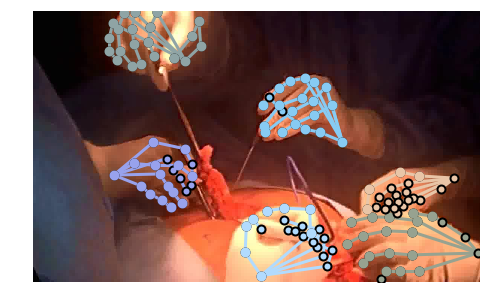

In [46]:
# modify the index for the specific folder, modify the img_id for specific frame
index = 11; img_id = 5;

# initialize COCO api for instance annotations
coco = COCO('coco_output_%03d.json'%index)
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['hand'])
imgIds = coco.getImgIds(catIds=catIds )
imgIds = coco.getImgIds(imgIds = img_id)
img = coco.loadImgs(imgIds)[0]
I = cv2.imread(osp.join('keypoints_%03d'%index,img['file_name']))
print(img['file_name'])
b,g,r = cv2.split(I)       # get b,g,r
I = cv2.merge([r,g,b])     # switch it to rgb
plt.axis('off')
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)